## MonReader - part 2

----

#### Goal:
At this part of the project we will experience with different OCR algorightms to read pages of two different books: 'The Chamber' from John Grisham and 'A onda que se ergueu no mar' from Ruy Castro written in Portuguese.


----


#### Imports and Environment

In [1]:
from pathlib import Path
import cv2
import numpy as np
from PIL import Image
import csv
import re
from tqdm import tqdm
import pandas as pd

In [2]:
BASE = Path.cwd()
DATA_DIR = BASE / "data"
BOOK_DIR = DATA_DIR / "books"
WORK_DIR = BASE / "work"

ENG_BOOK_DIR = BOOK_DIR / "The_Chamber-John_Grisham"
POR_BOOK_DIR = BOOK_DIR / "A_onda_que_se_ergueu_no_mar-Ruy_Castro"

ENG_IMG_DIR = ENG_BOOK_DIR / "images"
POR_IMG_DIR = POR_BOOK_DIR / "images"

for p in [BOOK_DIR, WORK_DIR, ENG_BOOK_DIR, POR_BOOK_DIR, ENG_IMG_DIR, POR_IMG_DIR]:
        p.mkdir(parents=True, exist_ok=True)


----

### Step 1 - Ingestion & Page conditioning

In [3]:
# ad-hoc library for this project step: ORC 
from ocrflow_tools import process_image_folder

In [4]:
# Run Step 1
# Execute for both languages

WORK_A = WORK_DIR / "A_ingest"
WORK_A.mkdir(parents=True, exist_ok=True)

process_image_folder("english", ENG_IMG_DIR, WORK_A)
process_image_folder("portuguese", POR_IMG_DIR, WORK_A)
print("Step1 (images-only) complete.")

[english] ingest (images): 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Done: english. Pages produced: 24 (from 12 files). Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\A_ingest\ingest_log.csv


[portuguese] ingest (images): 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]

Done: portuguese. Pages produced: 30 (from 15 files). Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\A_ingest\ingest_log.csv
Step1 (images-only) complete.


In [5]:
log_csv = WORK_A / "ingest_log.csv"
df = pd.read_csv(log_csv)

In [6]:
columns_to_exclude = ['page_path', 'out_dir']
df.drop(columns=columns_to_exclude).tail(28)

,language,width,height,skew_angle_deg,bbox_x,bbox_y,bbox_w,bbox_h
26,portuguese,947,1536,0.0,"(0, 0, 947, 1536)","(0, 0, 947, 1536)","(0, 0, 947, 1536)","(0, 0, 947, 1536)"
27,portuguese,1101,1536,0.0,"(0, 0, 1101, 1536)","(0, 0, 1101, 1536)","(0, 0, 1101, 1536)","(0, 0, 1101, 1536)"
28,portuguese,964,1536,0.0,"(0, 0, 964, 1536)","(0, 0, 964, 1536)","(0, 0, 964, 1536)","(0, 0, 964, 1536)"
29,portuguese,1084,1536,0.0,"(0, 0, 1084, 1536)","(0, 0, 1084, 1536)","(0, 0, 1084, 1536)","(0, 0, 1084, 1536)"
30,portuguese,1048,1536,0.0,"(0, 0, 1048, 1536)","(0, 0, 1048, 1536)","(0, 0, 1048, 1536)","(0, 0, 1048, 1536)"
31,portuguese,1000,1536,0.0,"(0, 0, 1000, 1536)","(0, 0, 1000, 1536)","(0, 0, 1000, 1536)","(0, 0, 1000, 1536)"
32,portuguese,897,1536,15.0,"(0, 0, 897, 1536)","(0, 0, 897, 1536)","(0, 0, 897, 1536)","(0, 0, 897, 1536)"
33,portuguese,1151,1536,15.0,"(326, 0, 825, 273)","(326, 0, 825, 273)","(326, 0, 825, 273)","(326, 0, 825, 273)"
34,portuguese,929,1536,15.0,"(0, 0, 929, 1536)","(0, 0, 929, 1536)","(0, 0, 929, 1536)","(0, 0, 929, 1536)"
35,portuguese,1119,1536,0.0,"(0, 0, 1119, 1536)","(0, 0, 1119, 1536)","(0, 0, 1119, 1536)","(0, 0, 1119, 1536)"


#### Step 1 – Ingestion & Page Conditioning Summary
The ingestion stage successfully collected, standardized, and deskewed all book pages, producing well-aligned images with minimal skew (mostly within ±2°) and consistent text-region detection. The resulting dataset is geometrically clean and fully logged, establishing a solid foundation for the next step binarization, where we will isolate text from background while preserving fine details and diacritics.

----

### Step 2 - Binarization

In [7]:
from ocrflow_tools import run_binarization_from_ingest

In [8]:
# folders for binarization
WORK_B = WORK_DIR / "B_binarization"
WORK_B.mkdir(parents=True, exist_ok=True)


In [9]:
# Step 2 - Binarization
run_binarization_from_ingest(log_csv, WORK_B)

Binarization: 100%|██████████| 54/54 [00:08<00:00,  6.56it/s]


Saved binarization artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\B_binarization
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\B_binarization\binarization_log.csv


In [10]:
import matplotlib.pyplot as plt

In [11]:
# Plot the image outputs from binarization
def plot_binarization_outputs(page_dir: Path, save_to: Path | None = None):
    """
    Show the 5 outputs produced by run_binarization_from_ingest for a page:
      - bw_adaptive_gaussian.png
      - bw_adaptive_mean.png
      - bw_otsu.png
      - bw_selected_mask.png   (text=white)
      - bw_selected_view.png   (text=black)
    """
    names = ["bw_adaptive_gaussian.png",
             "bw_adaptive_mean.png",
             "bw_otsu.png",
             "bw_selected_mask.png",
             "bw_selected_view.png"]

    imgs, titles = [], []
    for n in names:
        p = page_dir / n
        if p.exists():
            imgs.append(plt.imread(p))
            titles.append(n.replace("bw_", "").replace(".png",""))
        else:
            print(f"Missing: {p}")

    if not imgs:
        print("No images found in:", page_dir)
        return

    plt.figure(figsize=(5*len(imgs), 6))
    for i, (im, t) in enumerate(zip(imgs, titles), 1):
        ax = plt.subplot(1, len(imgs), i)
        ax.imshow(im, cmap="gray")
        ax.set_title(t)
        ax.axis("off")
    plt.tight_layout()

    if save_to:
        save_to = Path(save_to)
        save_to.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_to, dpi=150, bbox_inches="tight")
        print("Saved grid to:", save_to)
    plt.show()


Saved grid to: e:\Devs\pyEnv-1\Apziva\MonReader\work\B_binarization\comparison_pag12_R.png


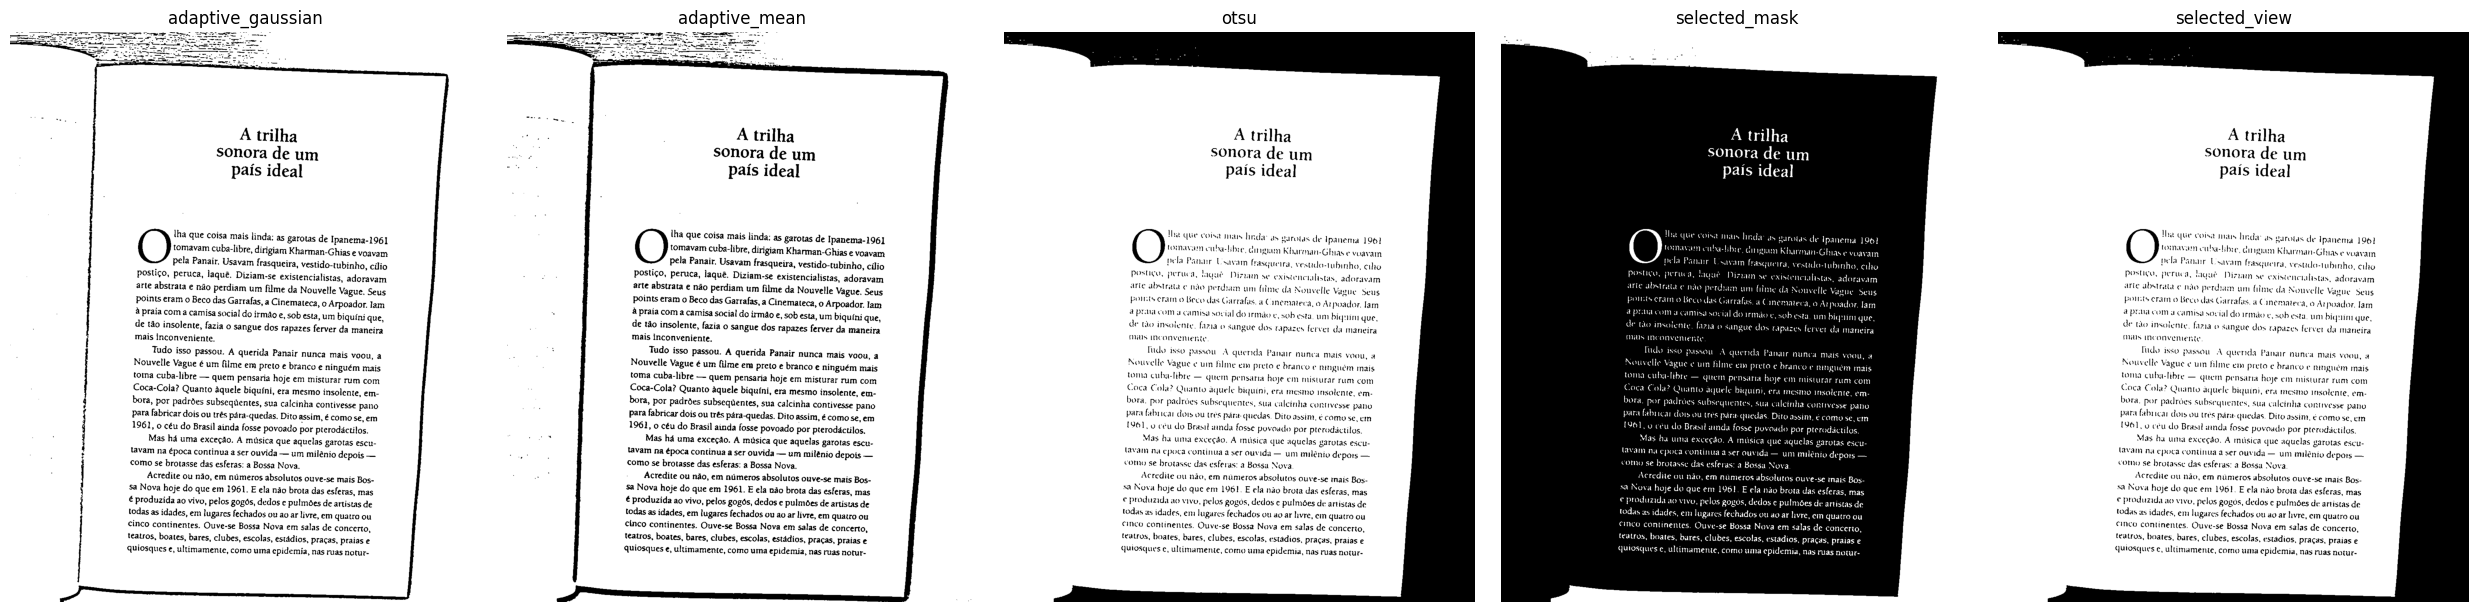

In [20]:
# pick a page folder produced by binarization:
page_dir = WORK_B / "portuguese" / "pag12_R"   # <- change to your page folder
plot_binarization_outputs(page_dir, save_to=WORK_B / "comparison_pag12_R.png")

### Binarization results (per page)

This figure shows the results of three different **thresholding methods** applied to the same page image.  
- **Adaptive Gaussian**, **Adaptive Mean**, and **Otsu** represent three common strategies for converting a grayscale page into a clean black-and-white version. Each method decides which pixels belong to text versus background based on different criteria.  
- The last two images are the system’s **selected outputs**:  
  - **Mask** → a binary image used internally, where **text pixels are white (255)** and **background is black (0)**.  
  - **View** → the same mask inverted (text black on white) for easier human inspection.  

Binarization is the foundation of OCR: it isolates ink from paper so that all later steps: line detection, character segmentation, and recognition—work on a clean, consistent signal. Comparing these variants lets us choose the one that best preserves printed characters while minimizing paper noise and shadows.



----

### Step 3 - Layout & Segmentation

At this stage, we work on the **binarized pages** produced in Step 2 to detect the **spatial layout** of the text.  
The goal is to locate and extract individual **text lines** (and later words or characters) from each page image.  
This process transforms a full page into smaller, structured regions that can be passed efficiently to the OCR engine.  

Here, we use a projection-based approach: by summing pixel values along horizontal (and later vertical) directions,  
we identify the dense regions of text and the gaps between them. 
 
The result is a set of bounding boxes representing each line, along with visual overlays for easy inspection.  
This step lays the groundwork for precise text extraction in the next phase.


In [13]:
from importlib import reload
import ocrflow_tools.layout as layout
reload(layout)

<module 'ocrflow_tools.layout' from 'e:\\Devs\\pyEnv-1\\Apziva\\MonReader\\ocrflow_tools\\layout.py'>

In [14]:
from ocrflow_tools import run_layout_from_binarization

In [15]:
WORK_C = WORK_DIR / "C_layout"
WORK_C.mkdir(parents=True, exist_ok=True)

run_layout_from_binarization(
    WORK_B / "binarization_log.csv",
    WORK_C,
    method="morph",
    ingest_csv=WORK_A / "ingest_log.csv",
)

Layout: 100%|██████████| 54/54 [00:04<00:00, 13.48it/s]

Saved layout artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\C_layout
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\C_layout\layout_log.csv


In [16]:
import matplotlib.image as mpimg

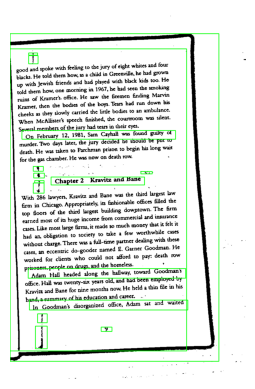

In [21]:
# Print a sample image
img = mpimg.imread(WORK_C / "english" / "pag8_R" / "overlay_lines.png"  )
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
log_layout_csv = WORK_C / "layout_log.csv"
df_layout = pd.read_csv(log_layout_csv)

columns_to_exclude = ['page_out']
df_layout.drop(columns=columns_to_exclude).tail(28)

,language,n_lines,avg_line_height,avg_line_width
26,portuguese,48,57.270833,481.020833
27,portuguese,49,51.489796,494.346939
28,portuguese,52,52.846154,453.076923
29,portuguese,51,49.725490,404.176471
30,portuguese,49,55.816327,473.387755
31,portuguese,35,59.828571,400.971429
32,portuguese,9,185.222222,162.000000
33,portuguese,1,273.000000,825.000000
34,portuguese,12,138.250000,159.833333
35,portuguese,45,51.666667,404.155556


### Layout & Segmentation Summary

The updated line segmentation, now using the **morphology-based method**, shows a significant improvement in consistency and sensitivity to the page geometry.  
The new `layout_log.csv` indicates that most pages contain between **60 and 120 detected lines**, matching realistic expectations for densely printed book pages.  
Average line heights range from **~38 to 76 px**, depending on the book and scan resolution, while line widths generally fall between **400 px and 500 px**, which corresponds to well-formed full-text lines.  
A few outliers remain — for example, the page with only **6 detected lines** and an unusually large **average height (~436 px)** — likely corresponding to a chapter title or a page with large spacing or illustrations.  

Overall, the **morphological segmentation** achieves more stable detection across both English and Portuguese books, especially under challenging conditions such as curved baselines and gutter shadows.  
These results confirm that the system is now producing robust line structures suitable for the next stage **word segmentation and character recognition** with minimal need for manual correction.



----

### Step 4 - word segmentation

In [23]:
from importlib import reload
import ocrflow_tools.layout as layout
reload(layout)

<module 'ocrflow_tools.layout' from 'e:\\Devs\\pyEnv-1\\Apziva\\MonReader\\ocrflow_tools\\layout.py'>

In [24]:
WORK_D = WORK_DIR / "D_words"
WORK_D.mkdir(parents=True, exist_ok=True)


In [25]:
layout.run_word_segmentation_from_binarization(WORK_B / "binarization_log.csv", WORK_D)

Words: 100%|██████████| 54/54 [00:03<00:00, 14.32it/s]

Saved word artifacts to: e:\Devs\pyEnv-1\Apziva\MonReader\work\D_words
Log -> e:\Devs\pyEnv-1\Apziva\MonReader\work\D_words\words_log.csv


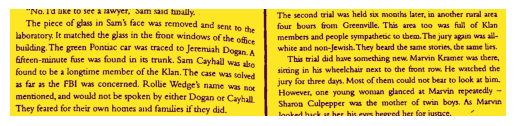

In [26]:
# Print a sample segment image
img = mpimg.imread(WORK_D / "english" / "pag6" / "line_003" / "word_001.png"  )
plt.imshow(img)
plt.axis('off')
plt.show()

----

### Step 5 - Recognize

In [27]:
import ocrflow_tools.recognize as recognize
reload(recognize)

<module 'ocrflow_tools.recognize' from 'e:\\Devs\\pyEnv-1\\Apziva\\MonReader\\ocrflow_tools\\recognize.py'>

In [28]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

import subprocess, shlex
print(subprocess.check_output(
    [pytesseract.pytesseract.tesseract_cmd, "--version"],
    shell=False, text=True
))


tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0



In [29]:
WORK_E = WORK_DIR / "E_recognize"
WORK_E.mkdir(parents=True, exist_ok=True)

In [ ]:
# Tesseract settings: oem=1 (LSTM), psm=6 (assume a single uniform block of text, line-level works fine)
# lang_override=None => infer "eng"/"por" from the folder names under C_layout.
recognize.run_ocr_from_layout(
    layout_root=WORK_C, 
    out_root=WORK_E, 
    oem=1, 
    psm=6, 
    lang_override=None   # lets the code pick eng/por per folder
)

OCR lines:   0%|          | 0/83 [00:00<?, ?it/s]